## Synthetic experiment 
This notebook shows some basic usage of the proposed toolbox. The synthetic dataset considered is a tri-variate sinusoidal signal composed by 3 sines with the same frequency and different phase. The first part of the experiment consists in interpolating the unobserved part of the functions given a finite set of noise-corrupted observations

In [2]:
from model import mogp_model
import numpy as np

## Synthetic data generation

In [3]:
#############################################################################################
#First, a simple example for 3 sine curves.
X_list = []
#We construct a new set of observations, noting that observations must be sorted according to X axis.
#We generate 100 random values from the interval [0,4) 3 times and store them in a list.
#Each element of the list is a sorted array of 100 values.
for new_observation in range(3):
    X_list.append(np.sort(np.random.uniform(0, 4, 100)))

#Now we generate our observations, based on the previously randomly chosen X values.
#Each element of y_list corresponds to one element of X_list (e.g: X_list[0] are the 
#X values of y_list[0]).
y_list = []
#Sine(6X) + Noise
y_list.append(np.sin(6*X_list[0]) + np.random.standard_t(3, X_list[0].shape)*0.03)
#Sine(6X+2) + Noise
y_list.append(np.sin(6*X_list[1] + 2) + np.random.standard_t(3, X_list[1].shape)*0.03)
#Sine(6X+2) - Sine(4X) + Noise
y_list.append(np.sin(6*X_list[2] + 2) - np.sin(4*X_list[2]) + np.random.standard_t(3, X_list[2].shape)*0.03)
#############################################################################################

## Model definition

In [4]:
#############################################################################################
#We define the model, stating the number of components Q.
model = mogp_model(3)
#############################################################################################

## Data insertion

In [5]:
#############################################################################################
#The model needs a specific format, so we transform our observations
#to comply with it. More information about this specific format in
# 'Add training data to the model' section of model.py .
model.add_training_data(X_list,y_list)
#############################################################################################

channels  [0 1 2]
elements per channel  [100 100 100]
input dimensions  1
output dimensions  3


## Model initialization

In [6]:
#############################################################################################
#We must first build the model with the current training data. When we do this, the
#model's parameters are chosen at random.
parameters = {'components': 3}
model.build_model('MOSM', 'full', parameters=parameters)
print(model.read_trainables())
#############################################################################################

{'GPR/kern/kernels/0/constant': array([-1.00111404,  0.51582865, -1.02688805]), 'GPR/kern/kernels/0/delay': array([[0., 0., 0.]]), 'GPR/kern/kernels/0/mean': array([[-0.00578094,  0.49800321,  0.59428071]]), 'GPR/kern/kernels/0/noise': array([0.40923558, 0.88357468, 0.04317145]), 'GPR/kern/kernels/0/phase': array([0., 0., 0.]), 'GPR/kern/kernels/0/variance': array([[0.05270928, 0.67369906, 0.53668839]]), 'GPR/kern/kernels/1/constant': array([ 0.52074192,  1.23634761, -0.63088947]), 'GPR/kern/kernels/1/delay': array([[0., 0., 0.]]), 'GPR/kern/kernels/1/mean': array([[ 0.41342759, -1.29392264,  0.23414891]]), 'GPR/kern/kernels/1/noise': array([0.6925239 , 0.35477623, 0.03604634]), 'GPR/kern/kernels/1/phase': array([0., 0., 0.]), 'GPR/kern/kernels/1/variance': array([[0.38993994, 0.85299409, 0.98816932]]), 'GPR/kern/kernels/2/constant': array([-0.19369773,  0.82930204,  1.47921078]), 'GPR/kern/kernels/2/delay': array([[0., 0., 0.]]), 'GPR/kern/kernels/2/mean': array([[-0.52905147, -1.0647

## Fit model through optimization

In [7]:
#############################################################################################
#We fit the model, for a max of 50 iterations, using the default optimizer L-BFGS-B.
model.optimize(iterations = 50, display=True)
#model.optimize_with_adam(iterations=2000, learning_rate = 0.001)
#############################################################################################

INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: -418.169787
  Number of iterations: 50
  Number of functions evaluations: 91


INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: -418.169787
  Number of iterations: 50
  Number of functions evaluations: 91


## Synthethic prediction data generation

In [8]:
#############################################################################################
#We can automatically generate a prediction interval.
#First argument is the point resolution (number of points).
#The second argument is a list containing the desired channels to predict upon.
X_pred = model.predict_interval(300, [0,1,2])
#############################################################################################

## Prediction

In [9]:
#############################################################################################
#We perform the prediction.
Y_pred, STD_pred = model.predict(X_pred)
#############################################################################################

## Optional: Latent functions for plots

In [10]:
#############################################################################################
#Since we know the functions that we're trying to approximate (without noise)...
def latent1(x):
    return np.sin(6*x)

def latent2(x):
    return np.sin(6*x + 2)

def latent3(x):
    return np.sin(6*x + 2) - np.sin(4*x)
#...we can declare a set of latent functions in the model. The first argument is the set of 
#functions, and the second argument contains the corresponding channels. This is entirely optional,
#and it is not used to perform anything in the model, it's only for plotting purposes.
model.define_latent_functions([latent1, latent2, latent3], [0,1,2])
#############################################################################################

## Plotting

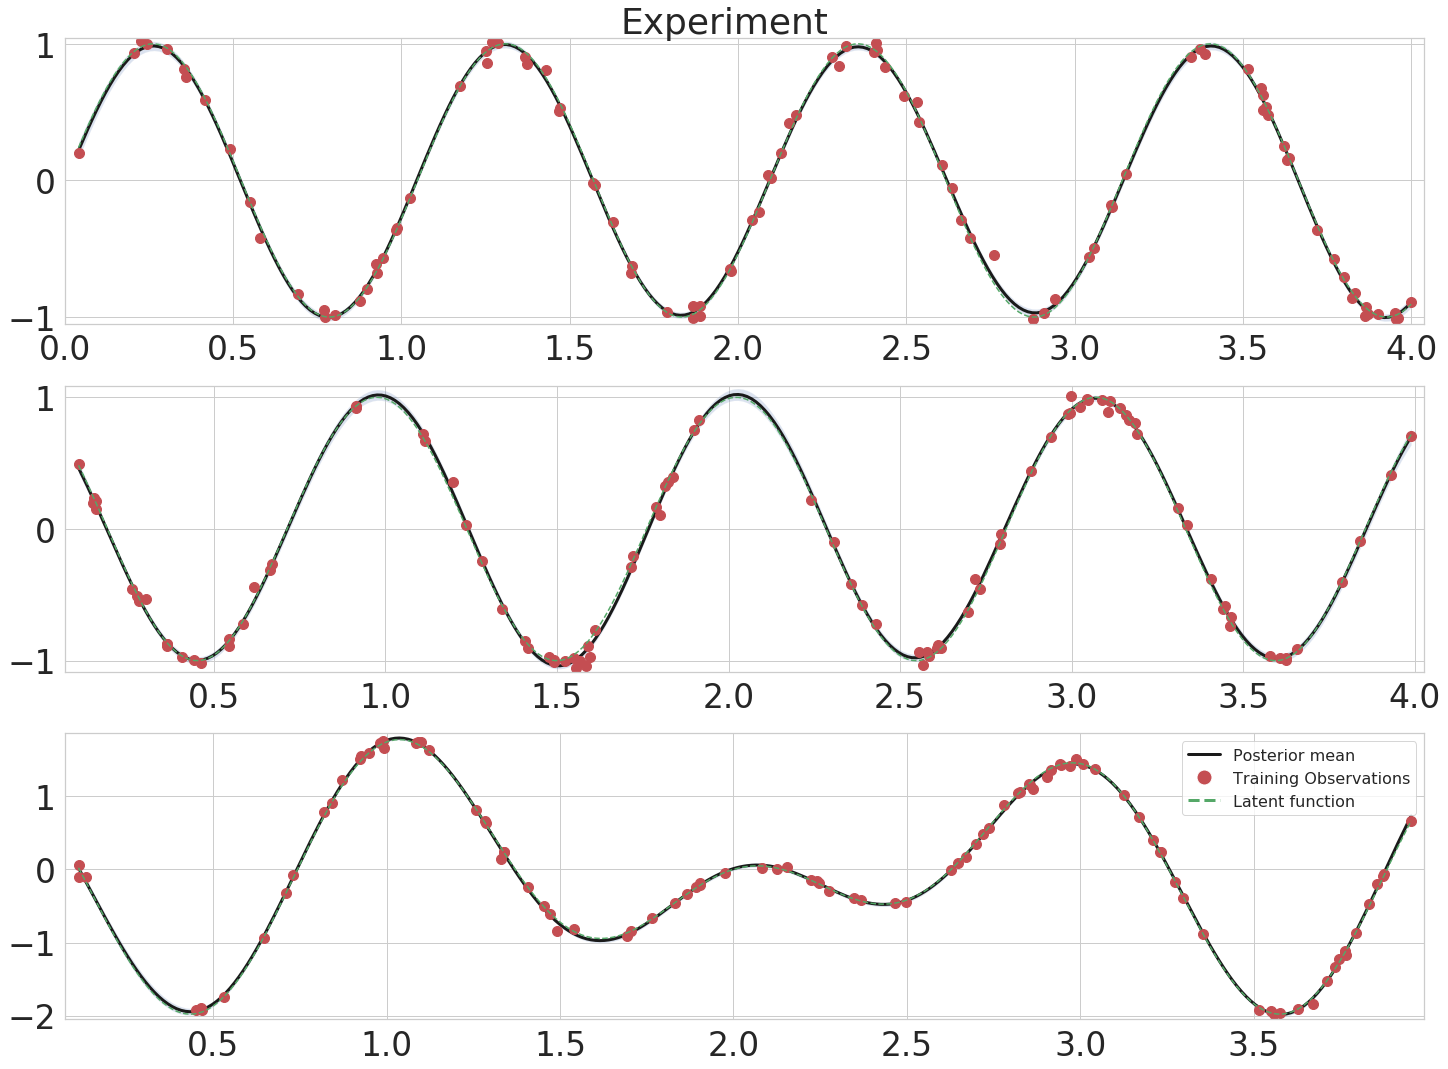

In [11]:
#############################################################################################
#We can save plots for our prediction.
model.make_plots("experiment.png")
#############################################################################################

## Parameter inspection

In [12]:
#############################################################################################
#We can inspect the trained model parameters.
print(model.as_pandas_table())
#############################################################################################

                                 class prior       transform  trainable  \
GPR/kern/kernels/0/constant  Parameter  None          (none)       True   
GPR/kern/kernels/0/delay     Parameter  None  PartiallyFixed       True   
GPR/kern/kernels/0/mean      Parameter  None          (none)       True   
GPR/kern/kernels/0/noise     Parameter  None             +ve       True   
GPR/kern/kernels/0/phase     Parameter  None  PartiallyFixed       True   
GPR/kern/kernels/0/variance  Parameter  None             +ve       True   
GPR/kern/kernels/1/constant  Parameter  None          (none)       True   
GPR/kern/kernels/1/delay     Parameter  None  PartiallyFixed       True   
GPR/kern/kernels/1/mean      Parameter  None          (none)       True   
GPR/kern/kernels/1/noise     Parameter  None             +ve       True   
GPR/kern/kernels/1/phase     Parameter  None  PartiallyFixed       True   
GPR/kern/kernels/1/variance  Parameter  None             +ve       True   
GPR/kern/kernels/2/consta

## Another example with missing data
In the following section we'll remove information from the channels to test the reconstruction capabilities offered by the model.

## Synthetic data generation

In [13]:
import gpflow
gpflow.reset_default_graph_and_session()
#############################################################################################
X_list = []
y_list = []
for new_observation in range(3):
    X_list.append(np.sort(np.random.uniform(1, 4, 100)))
    
y_list.append(np.sin(6*X_list[0]) + np.random.standard_t(3, X_list[0].shape)*0.03)
y_list.append(np.sin(6*X_list[1] + 6) + np.random.standard_t(3, X_list[1].shape)*0.03)
y_list.append(np.sin(6*X_list[2]) + np.cos(6*X_list[2]) + np.log(2*X_list[2]) + np.random.standard_t(3, X_list[2].shape)*0.03)
#############################################################################################

## Model definition

In [14]:
#############################################################################################
#We create a model with 4 components and with L-BFGS-B as the optimization method.
model = mogp_model(4, optimizer='L-BFGS-B')
#############################################################################################

## Delete observations at random

In [15]:
#############################################################################################
#The following method removes slabs from the time series of each channel, in order to mimic
#temporary sensor failure.
X_list_modified, y_list_modified, X_removed, y_removed = model.remove_slabs(X_list, y_list)
#############################################################################################

## Data insertion

In [16]:
#############################################################################################
#We must first add the training data to the model, in multioutput format.
#X,y = model.transform_lists_into_multioutput_format(X_list_modified, y_list_modified)
model.add_training_data(X_list_modified,y_list_modified)
#############################################################################################

channels  [0 1 2]
elements per channel  [84 84 72]
input dimensions  1
output dimensions  3


## Model initialization

In [17]:
#############################################################################################
#Then we must build the model.
parameters = {'components': 3}
model.build_model('MOSM', 'full', parameters=parameters)
#############################################################################################

## Fit Model

In [18]:
#############################################################################################
#After the model is built, we may optimize parameters.
model.optimize(iterations=300, display=True)
#model.optimize_with_adam(iterations=2000, learning_rate = 0.001)
#############################################################################################

INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: -352.455719
  Number of iterations: 300
  Number of functions evaluations: 375


INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: -352.455719
  Number of iterations: 300
  Number of functions evaluations: 375


## Optional: Latent functions for plots

In [19]:
#############################################################################################
def latent1(x):
    return np.sin(6*x)
def latent2(x):
    return np.sin(6*x + 6)
def latent3(x):
    return np.sin(6*x) + np.cos(6*x) + np.log(2*x)
model.define_latent_functions([latent1, latent2, latent3], [0,1,2])
#############################################################################################

## Synthetic prediction data generation

In [20]:
#############################################################################################
#This time we'll modify the prediction interval to span an extra 0.5 units in X axis.
#We do this to observe the model's regression capabilities.
#First argument is point resolution.
#Second argument specifies the desired channels.
#Start has all the starting points, for each specified channel.
#End has all the ending points, for each specified channel.
X_pred = model.predict_interval(300, [0,1,2], start=[[1],[1],[1]], end=[[4.5],[4.5],[4.5]])
#############################################################################################

## Perform prediction

In [21]:
#############################################################################################
Y_pred, STD_pred = model.predict(X_pred)
#############################################################################################

## Plotting

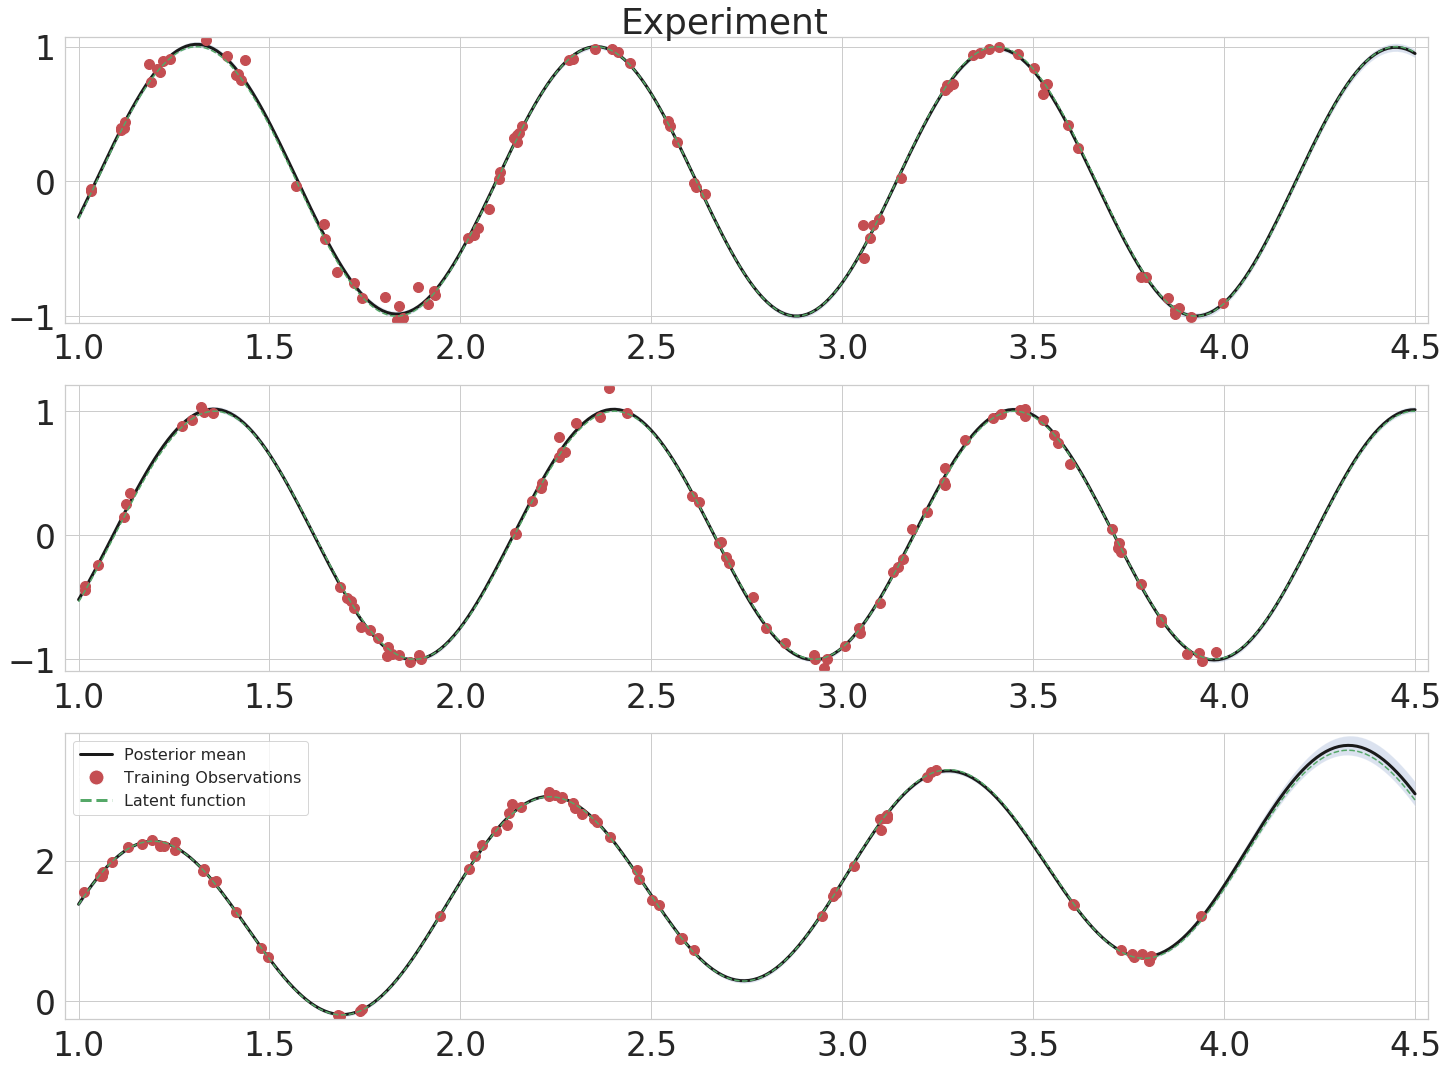

In [22]:
#############################################################################################
#We could plot the same way as in the previous experiment.
model.make_plots("deletion_experiment.png")
#############################################################################################

## Plotting with deleted data points

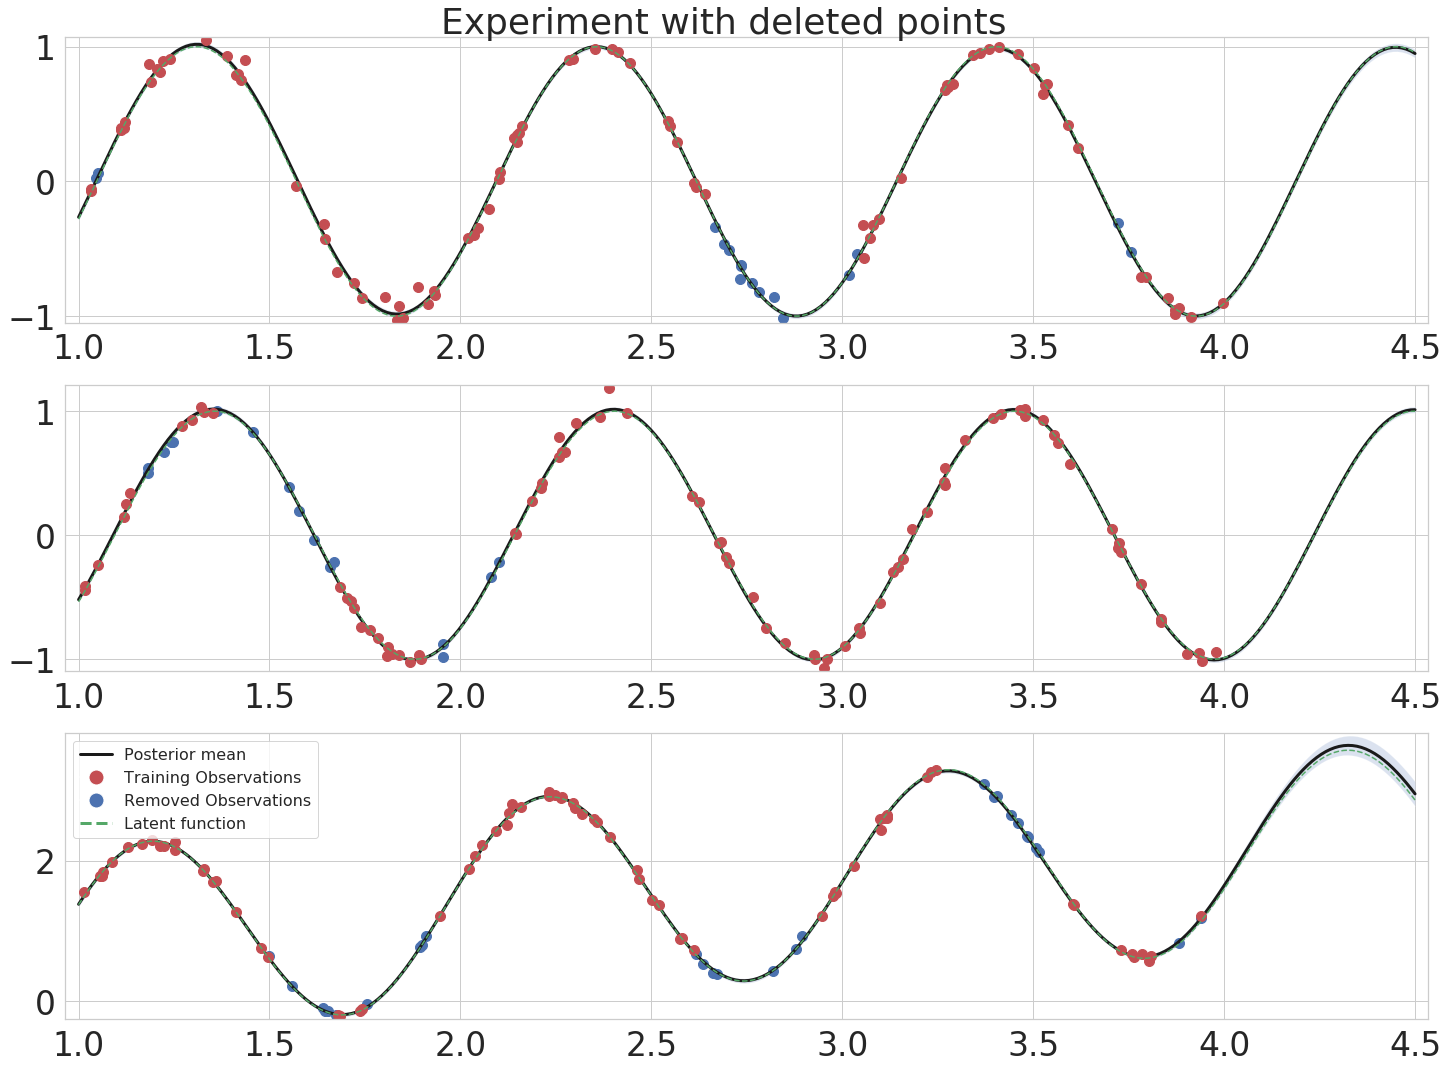

In [23]:
#But we can also add all the deleted observations and make a new plot.
#This way the removed points, which are not used to train the model, are plotted in blue.
#We must specify the channels to which the information belongs to, in the order it is provided.
model.add_extra_observations(X_removed,y_removed,[0,1,2])
#We can specify the shape for the resulting plots, [3,1] means 3 rows 1 column.
model.make_plots("deletion_experiment_with_extra_obs.png", shape = [3,1], title='Experiment with deleted points')